In [28]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [29]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [30]:
api = wandb.Api(timeout=200)

In [31]:
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "basline_ppo_10m": "PPO-clip",
    "xppo_single_step_4096": "xPPO",
    "basline_stbl_ppo": "PPO-clip",
    'xppo_single_step_large_historic': "xPPO $|D_{h}|=128000$",
    "xppo_single_step_no_historic": "xPPO $|D_{h}|=4096$",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'env': "Environment",
    'rollout/SuccessRate':'Average Success Rate',
    'train/std': "Action Distribution STD",
    "<SawyerPushEnvV2 instance>":"push",
    "<SawyerWindowCloseEnvV2 instance>":"window-close",
    "<SawyerDoorEnvV2 instance>":"door-open",
    "<SawyerReachEnvV2 instance>":"reach",
    "<SawyerButtonPressTopdownEnvV2 instance>":"button-press-topdown",
    "<SawyerWindowOpenEnvV2 instance>":"window-open",
    "<SawyerDrawerOpenEnvV2 instance>":"drawer-open",
    "<SawyerPegInsertionSideEnvV2 instance>":"peg-insert-side",
    "<SawyerDrawerCloseEnvV2 instance>":"drawer-close",
}
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerPickPlaceEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]

In [32]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
    return pd.concat(all_interp_data, ignore_index=True)

## Pick-Place

In [33]:
env = "PickPlace-V2"
env = "PickPlace-V2"
config_env = "<SawyerPickPlaceEnvV2 instance>"
total_steps=20e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate")
]
state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, state_env_filter]}

extra_filter = {"$or": [state_env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 5 runs for group xppo_single_step_4096
Got 11 runs for group basline_stbl_ppo


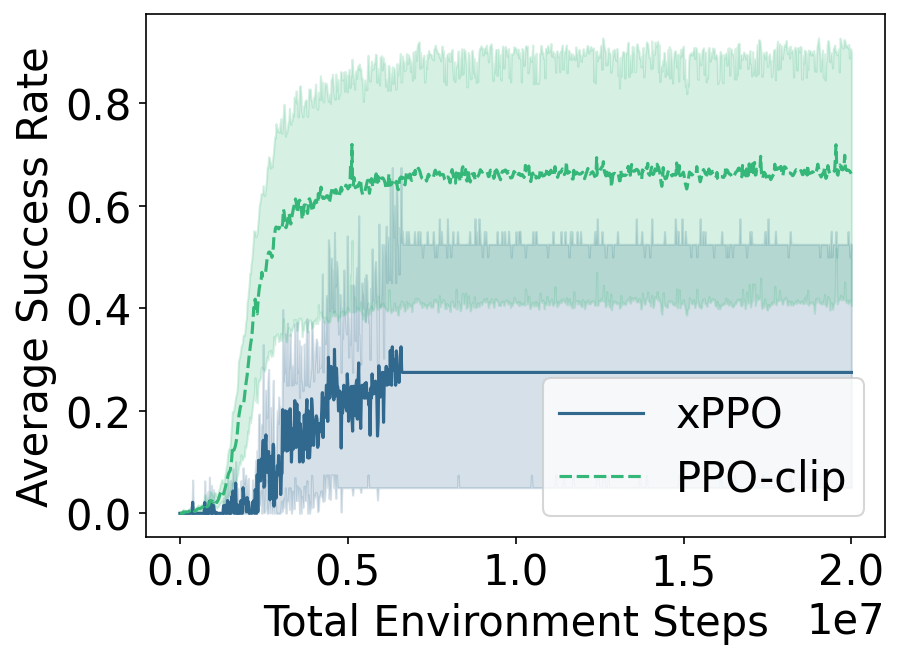

In [34]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}.pdf")

## Window-Open

In [35]:
env = "WindowOpen-V2"
config_env="<SawyerWindowOpenEnvV2 instance>"
total_steps=20e6

group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate")
]

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, state_env_filter]}

extra_filter = {"$or": [state_env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 6 runs for group xppo_single_step_4096
Got 12 runs for group basline_stbl_ppo


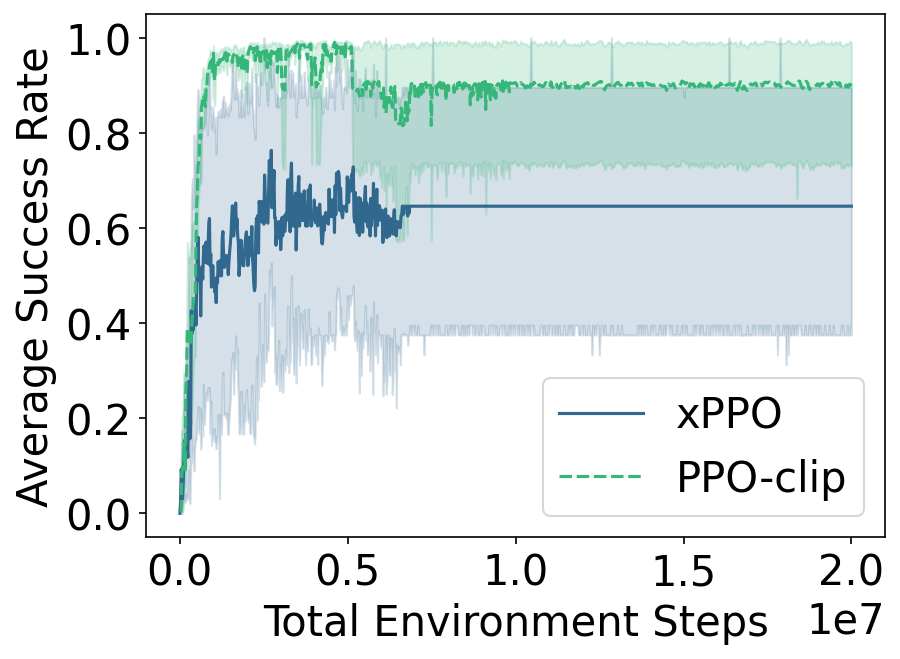

In [36]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")

plt.tight_layout()
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}.pdf")

## Reach

In [37]:
env = "Reach-V2"
config_env="<SawyerReachEnvV2 instance>"
total_steps=20e6

group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "rollout/SuccessRate"),
    ("basline_stbl_ppo", 'global_step', "rollout/SuccessRate")
]

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, state_env_filter]}

extra_filter = {"$or": [state_env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 5 runs for group xppo_single_step_4096
Got 11 runs for group basline_stbl_ppo


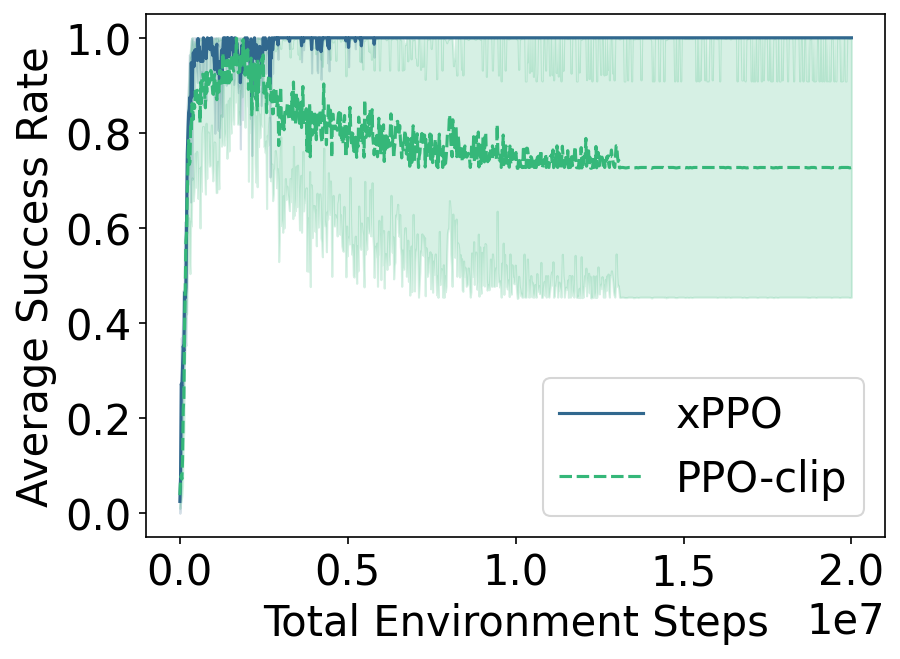

In [38]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Success Rate",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"XPPO_{env}.pdf")